# Programming Assignment \#2
## Eren Akgunduz

In [1]:
import os
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Logger

The logging system **definitely** came in handy when I was testing my code in the Python script. Although it *does* also work within this notebook, I feel that it's unnecessary and creates clutter for the outputs. In the interest of displaying only the necessary plots and info, I changed the logging level here to warnings only (to keep it quiet).

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

fh = logging.StreamHandler()
fmt = logging.Formatter(
    "%(asctime)s %(levelname)s %(lineno)d:%(filename)s(%(process)d) - %(message)s"
)
fh.setFormatter(fmt)
logger.addHandler(fh)

In [3]:
# --- all tuning parameters ---
# grid of tuning parameters represented by lambda
l = np.array([10**-2, 10**-1, 1, 10, 10**2, 10**3, 10**4, 10**5, 10**6])
a = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])  # alpha

### Functions

In [4]:
def preprocess_data(filename: str) -> tuple:
    "Take in raw data and convert it to a workable format/state"
    if not isinstance(filename, str):
        raise TypeError("Filename should be a string :)")

    try:
        datafile = f"{os.getcwd()}/{filename}"
        logger.debug(datafile)
        if not os.path.exists(datafile):
            raise OSError("Expected data file, didn't find it :/")

        df = pd.read_csv(datafile, sep=",")  # read and pass to dataframe
        mapping = {
            "Gender": {"Male": 0, "Female": 1},
            "Student": {"No": 0, "Yes": 1},
            "Married": {"No": 0, "Yes": 1},
        }  # so no ambiguity about how we encode categorical columns
        df = df.replace(mapping)

        # convert dataframe to numpy array for faster computations
        return (df.columns.to_numpy(), np.array(df))
    except OSError:
        print("Couldn't load in the data due to OS error.")
        sys.exit("Check if things are right and try again :)")

In [5]:
def elastic_net(data) -> tuple:
    "Establish design matrix and response vector, prepare both for elastic net"
    y = data[:, 9]  # extract only the data from the output column (balance)
    y = (lambda c: c - c.mean())(y)  # IIFE to center response vector
    logger.debug(y.shape)
    logger.debug(y.mean())

    dm = np.delete(data, 9, axis=1)  # extract the design matrix
    X = (dm - np.mean(dm, axis=0)) / np.std(dm, axis=0)  # standardize (center & scale)

    logger.debug(X.shape)
    logger.debug(np.mean(X[:, 6]))
    logger.debug(np.std(X[:, 6]))
    return (X, y)

In [6]:
def coordinate_descent(X, y, l, a) -> np.ndarray:
    "Implementation of vectorized coordinate descent, applying elastic net"

    def cd(l: int, a: float):
        # b vector, each value (b_k) remains constant
        b = np.array([np.sum(X[:, k] ** 2) for k in range(X.shape[1])])
        # starting parameters vector
        beta = np.array([np.random.rand() for _ in range(X.shape[1])])
        for _ in range(1000):  # total iterations
            for k, _ in enumerate(beta):
                x_k = X[:, k]
                a_k = x_k.T @ (y - X @ beta + x_k * beta[k])
                relu = np.maximum(0, np.abs(a_k) - (l * (1 - a) / 2))
                beta[k] = np.sign(a_k) * relu / b[k] + l * a
        return beta

    coeffs = np.zeros((6, 9, 9))

    if not isinstance(l, int) and not isinstance(a, float):
        for i_a, val_a in enumerate(a):
            for i_l, val_l in enumerate(l):
                beta = cd(val_l, val_a)
                coeffs[i_a, i_l] = beta
    else:
        coeffs = cd(l, a)
    return coeffs

In [7]:
def cross_validation(data, k: int = 5) -> np.ndarray:
    "Implementation of relevant gradient descent utilizing k-fold cross validation"
    if not isinstance(k, int):
        raise TypeError("Number of folds should be an integer :)")

    data_shuffled = data  # make a copy of the original data
    # shuffle the copy so the data in each fold are randomly determined
    # np.random.seed(0)
    np.random.shuffle(data_shuffled)
    logger.debug(f"{data_shuffled.shape}\n{data_shuffled}")

    # create tensor containing each equally shaped fold
    folds = np.array(np.split(data_shuffled, k))  # splits row-wise by default
    logger.debug(f"{folds.shape}\n{folds}")  # confirm that things look right

    cv_errors = []
    for index, fold in enumerate(folds):
        logger.debug(index)
        train = np.delete(folds, index, axis=0)
        train = train.reshape(-1, train.shape[2])
        validation = fold
        # logger.debug(f"{train.shape}\n{validation.shape}")
        # logger.debug(train[:1])
        # logger.debug(validation[:1])
        train_X, train_y = elastic_net(train)
        val_X, val_y = elastic_net(validation)
        b = coordinate_descent(train_X, train_y, l, a)
        # after preparing and training data, once again check that things look ok
        logger.debug(f"{l.shape} {b.shape} {val_X.shape} {b[0].shape} {val_y.shape[0]}")
        mse = [
            [
                (
                    (val_y - val_X @ b[i_a, i_l]).T
                    @ (val_y - val_X @ b[i_a, i_l])
                    / val_y.shape[0]
                )
                for i_l, _ in enumerate(l)
            ]
            for i_a, _ in enumerate(b)
        ]
        cv_errors.append(mse)

    cv_error = np.array(cv_errors).T
    logger.debug(f"{cv_error.shape} {cv_error}")
    cv_error = cv_error.mean(axis=2)
    logger.debug(f"{cv_error.shape} {cv_error}")
    return cv_error

In [8]:
columns, data = preprocess_data("Credit_N400_p9.csv")  # unpack the tuple

### Deliverable \#1

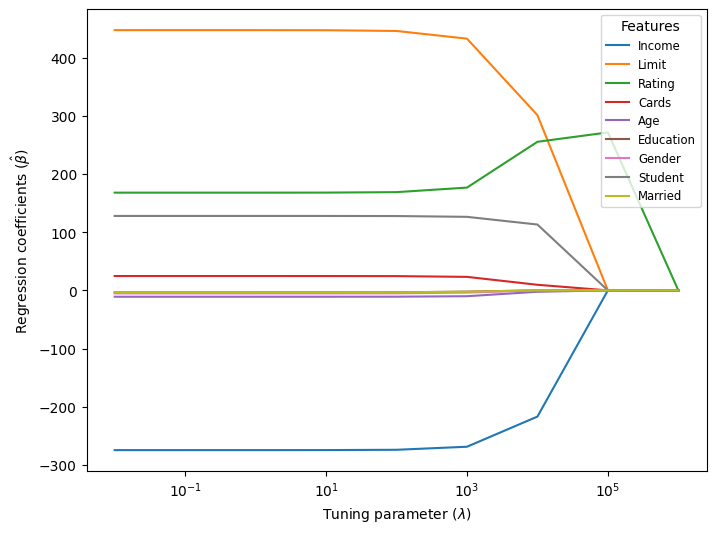

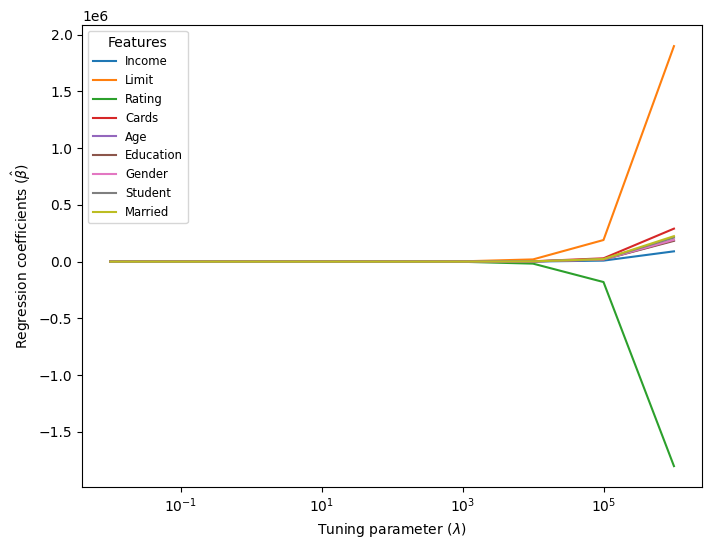

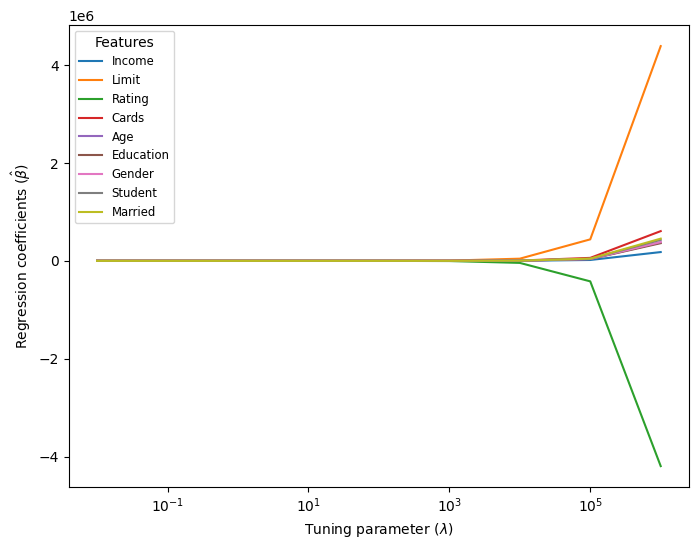

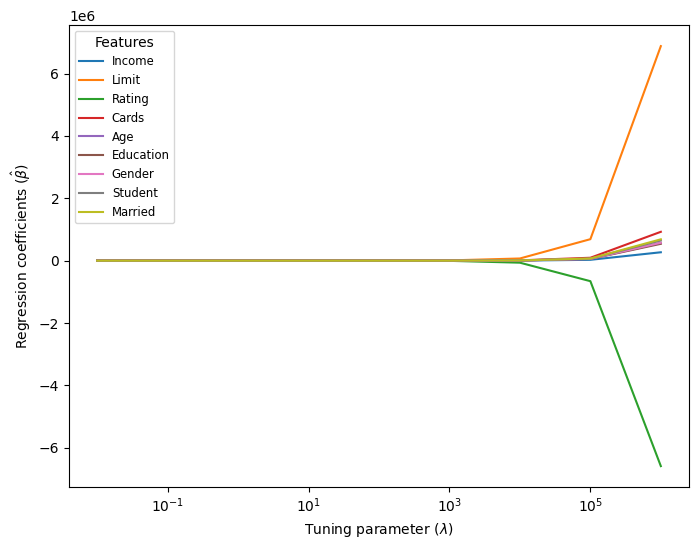

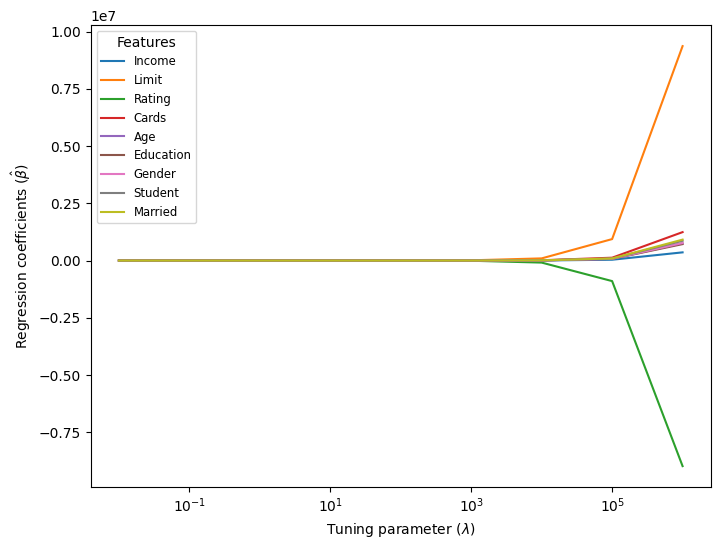

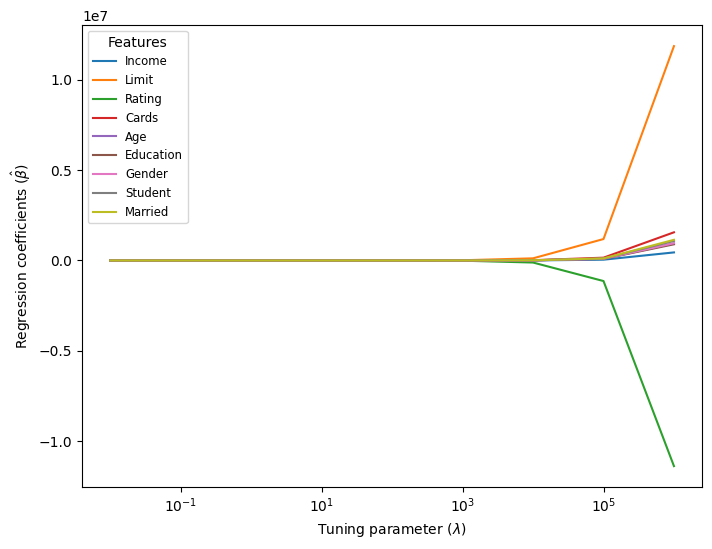

In [9]:
X, y = elastic_net(data)
B = coordinate_descent(X, y, l, a)
logger.debug(f"{B.shape}\n{B}")
for index, alpha in enumerate(B):
    plt.figure(figsize=(8, 6))
    plt.xscale("log")
    # transpose so that each row is one of the nine features with the nine columns for TP
    # this way, each index (row) has the vector I need to plot points
    [plt.plot(l, b, label=f"{columns[i]}") for i, b in enumerate(alpha.T)]
    plt.xlabel(r"Tuning parameter ($\lambda$)")
    plt.ylabel(r"Regression coefficients ($\hat{\beta}$)")
    plt.legend(title="Features", fontsize="small")
    plt.show()

### Deliverable \#2

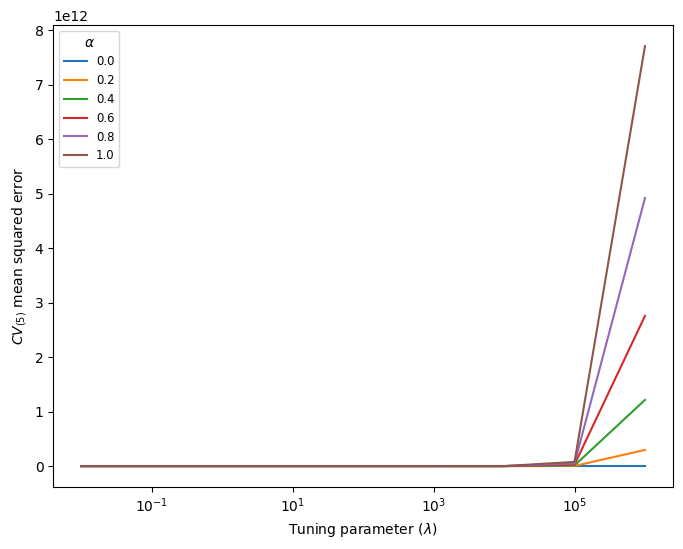

In [10]:
cv_error = cross_validation(data)
plt.figure(figsize=(8, 6))
plt.xscale("log")
[plt.plot(l, cv, label=f"{a[i]}") for i, cv in enumerate(cv_error.T)]
plt.xlabel(r"Tuning parameter ($\lambda$)")
plt.ylabel(r"$CV_{(5)}$ mean squared error")
plt.legend(title=r"$\alpha$", fontsize="small")
plt.show()

### Deliverable \#3

In [11]:
logger.debug(cv_error.argmin())
logger.debug(cv_error.min())
logger.debug(
    cv_error[
        cv_error.argmin() // cv_error.shape[1],  # gets the row
        cv_error.argmin() % cv_error.shape[1],  # gets the column
    ]
)
l_optimal = int(l[cv_error.argmin() // cv_error.shape[1]])
a_optimal = float(a[cv_error.argmin() % cv_error.shape[1]])

In [12]:
l_optimal

1000

In [13]:
a_optimal

0.0

### Deliverable \#4

In [14]:
B = coordinate_descent(X, y, l_optimal, a_optimal)

In [15]:
B

array([-268.8246833 ,  432.81235507,  176.70418218,   23.22054562,
        -10.04233612,   -2.17202387,   -3.78502227,  126.41592131,
         -2.37441118])

In [16]:
B = coordinate_descent(X, y, l_optimal, a[0])  # lasso, same arguments as before

In [17]:
B

array([-268.82471441,  432.82498633,  176.69157931,   23.22108554,
        -10.04231913,   -2.17208939,   -3.78502283,  126.41599841,
         -2.37432481])

In [18]:
B = coordinate_descent(X, y, l_optimal, a[5])  # ridge

In [19]:
B

array([   172.06592253,  12306.91725532, -11209.38117346,   1583.57068742,
          929.84626373,    892.6060773 ,    951.67462724,   1207.11541156,
         1140.55965738])